Import necessary libraries

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, RandomTranslation, RandomRotation, RandomFlip

from keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

In [8]:
images = np.load('images.npy')
labels = np.load('labels.npy')

encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

NUM_CLASSES = labels.shape[1]

In [9]:

def getCNNModel():
    model = Sequential([
        Input(shape=(64, 64, 1)),
        # RandomTranslation(0.1, 0.1),
        # RandomRotation(0.5),
        # RandomFlip(),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),   
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])
    return model

In [10]:
IMG_train, IMG_test, LBL_train, LBL_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [14]:
k = 2
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

best_val_acc = -1
best_model = None

for i, (train_idxs, val_idxs) in enumerate(kfold.split(IMG_train, LBL_train)):
    print(f"Fold {i + 1}/{k}")
    
    model = getCNNModel()
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_data = (IMG_train[train_idxs], LBL_train[train_idxs])
    val_data=(IMG_train[val_idxs], LBL_train[val_idxs])

    history = model.fit(*train_data, validation_data=val_data, batch_size=128, epochs=20)
    if history.history['val_accuracy'][-1] > best_val_acc:
        best_val_acc = history.history['val_accuracy'][-1]
        best_model = model

Fold 1/2
Epoch 1/20
401/401 [==============================] - 29s 69ms/step - loss: 3.1483 - accuracy: 0.2801 - auc_4: 0.8848 - val_loss: 1.1853 - val_accuracy: 0.6829 - val_auc_4: 0.9891
Epoch 2/20
401/401 [==============================] - 28s 70ms/step - loss: 1.1096 - accuracy: 0.6874 - auc_4: 0.9819 - val_loss: 0.6476 - val_accuracy: 0.8155 - val_auc_4: 0.9913
Epoch 3/20
401/401 [==============================] - 26s 66ms/step - loss: 0.7013 - accuracy: 0.7998 - auc_4: 0.9889 - val_loss: 0.7055 - val_accuracy: 0.8108 - val_auc_4: 0.9853
Epoch 4/20
401/401 [==============================] - 26s 66ms/step - loss: 0.5271 - accuracy: 0.8477 - auc_4: 0.9918 - val_loss: 1.7942 - val_accuracy: 0.5683 - val_auc_4: 0.9452
Epoch 5/20
401/401 [==============================] - 28s 69ms/step - loss: 0.4414 - accuracy: 0.8705 - auc_4: 0.9935 - val_loss: 0.6061 - val_accuracy: 0.8232 - val_auc_4: 0.9906
Epoch 6/20
401/401 [==============================] - 29s 73ms/step - loss: 0.3743 - accura

In [15]:
best_model.save('best_cnn_model.h5')


/home/miikey_lol/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from keras.models import load_model
from keras.models import Model

cnn_model: Sequential = load_model('best_cnn_model.h5')

In [16]:
feature_output = cnn_model.layers[-4].output 
feature_model = Model(inputs=cnn_model.input, outputs=feature_output)

In [17]:
train_features = feature_model.predict(IMG_train)
test_features = feature_model.predict(IMG_test)

801/801 [==============================] - 6s 7ms/step


In [26]:
print(train_features.shape)

(102528, 512)


In [18]:
# Convert from one-hot encoding to integer encoding
LBL_train_int = np.argmax(LBL_train, axis=1)
LBL_test_int = np.argmax(LBL_test, axis=1)

In [19]:
# Convert from integer encoding back to original labels
LBL_train_original = encoder.inverse_transform(LBL_train_int)
LBL_test_original = encoder.inverse_transform(LBL_test_int)

In [27]:
logistic_regressor = LogisticRegression(solver='lbfgs', max_iter=400)
logistic_regressor.fit(train_features, LBL_train_original)

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400)

In [24]:
predictions = logistic_regressor.predict(test_features)

In [25]:
from sklearn.metrics import classification_report

report = classification_report(LBL_test_original, predictions)
print(report)

              precision    recall  f1-score   support

           一       0.99      0.99      0.99       157
           七       0.94      0.95      0.94       128
           三       0.99      0.96      0.97       134
           上       0.98      0.96      0.97       133
           下       0.96      0.97      0.97       141
           不       0.94      0.98      0.96       137
           东       0.93      0.91      0.92       147
           个       0.95      0.98      0.96       135
           中       0.98      0.94      0.96       147
           么       0.96      0.96      0.96       156
           九       0.97      0.93      0.95       142
           习       0.96      0.97      0.97       159
           书       0.96      0.97      0.97       142
           买       0.98      0.93      0.96       151
           了       0.96      0.96      0.96       142
           二       0.98      0.98      0.98       131
           五       0.95      0.98      0.96       161
           些       0.97    

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Create an instance of the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the training data
knn.fit(train_features, LBL_train_original)

KNeighborsClassifier(n_neighbors=3)

In [29]:
# Predict the labels for the test data
knn_predictions = knn.predict(test_features)

In [30]:
report = classification_report(LBL_test_original, knn_predictions)
print(report)

              precision    recall  f1-score   support

           一       0.99      0.99      0.99       157
           七       0.80      0.92      0.86       128
           三       0.81      0.97      0.88       134
           上       0.88      0.98      0.93       133
           下       0.87      0.96      0.92       141
           不       0.91      0.98      0.94       137
           东       0.84      0.83      0.84       147
           个       0.89      0.97      0.93       135
           中       0.89      0.95      0.91       147
           么       0.81      0.98      0.89       156
           九       0.88      0.91      0.90       142
           习       0.84      0.99      0.91       159
           书       0.93      0.95      0.94       142
           买       0.93      0.91      0.92       151
           了       0.86      0.99      0.92       142
           二       0.96      0.98      0.97       131
           五       0.89      0.96      0.92       161
           些       0.90    

In [43]:
from PIL import Image, ImageOps

def numpy_to_image(numpy_array):
    return Image.fromarray(numpy_array.astype('uint8'))

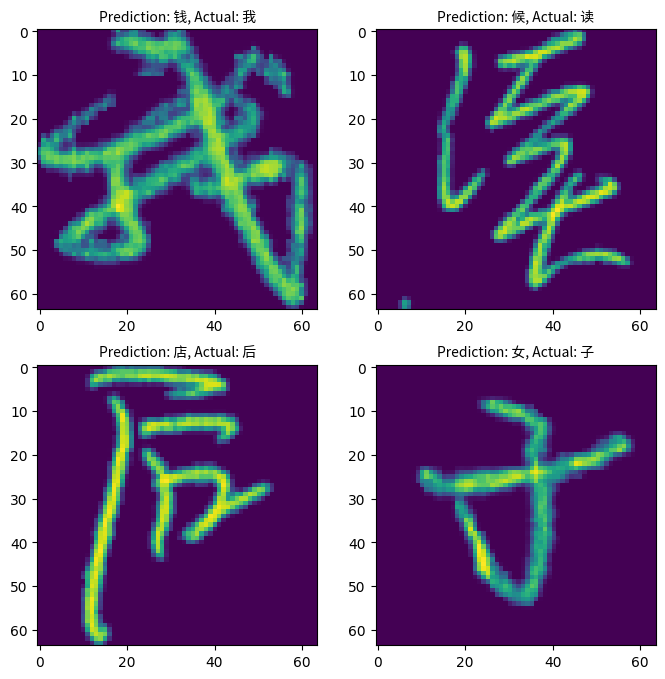

In [89]:
import random

# Get the indices of correct and wrong predictions
correct_indices = np.where(predictions == LBL_test_original)[0]
wrong_indices = np.where(predictions != LBL_test_original)[0]

random.seed(9)

correct_indices = random.sample(list(correct_indices), 4)
wrong_indices = random.sample(list(wrong_indices), 4)

correct_images = [IMG_test[idx] for idx in correct_indices]
wrong_images = [IMG_test[idx] for idx in wrong_indices]

correct_pred = (correct_indices, correct_images)
wrong_pred = (wrong_indices, wrong_images)

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for idxs, images in (wrong_pred, ):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(2):
        for j in range(2):
            idx = idxs[2 * i + j]
            numpy_image = images[2 * i + j]
            img = numpy_to_image(numpy_image)
            img = ImageOps.invert(img)
            axs[i][j].imshow(img)
            axs[i][j].set_title(f"Prediction: {predictions[idx]}, Actual: {LBL_test_original[idx]}", fontproperties=prop)
